## Importando Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

## Leitura dos dados

In [2]:
dataset = pd.read_csv('order_reviews.csv', sep=';')

In [3]:
dataset.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


## Pré-processamento dos dados

In [4]:
dataset.drop(['review_id', 'review_creation_date', 'review_answer_timestamp', 'review_comment_title', 'order_id'], axis=1, inplace=True)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_score            99224 non-null  int64 
 1   review_comment_message  40977 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [6]:
# Retirando o valores Null de reviews
dataset = dataset.dropna()

## Bag of Words: criando representações da linguagem humana.

In [7]:
# Vetorizando as 50 palavras com mais ocorrência da coluna "review_comment_message"
vetorizar = CountVectorizer(max_features=50)
bag_of_words = vetorizar.fit_transform(dataset['review_comment_message'])
bag_of_words.shape

(40977, 50)

In [8]:
# Visualização das 50 palavras com mais ocorrência
vetorizar.get_feature_names()

c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['ainda',
 'antes',
 'as',
 'até',
 'bem',
 'bom',
 'chegou',
 'com',
 'como',
 'compra',
 'comprei',
 'da',
 'de',
 'dentro',
 'do',
 'em',
 'entrega',
 'entregue',
 'estou',
 'eu',
 'excelente',
 'foi',
 'gostei',
 'loja',
 'mais',
 'mas',
 'me',
 'meu',
 'minha',
 'muito',
 'na',
 'no',
 'não',
 'os',
 'para',
 'por',
 'prazo',
 'produto',
 'qualidade',
 'que',
 'recebi',
 'recomendo',
 'rápida',
 'super',
 'só',
 'tudo',
 'um',
 'uma',
 'veio',
 'ótimo']

## Criando uma BaseLine

### Separando dados em treino e teste

In [9]:
# verificar a proporção do review score
dataset.review_score.value_counts().sort_index()

1     8745
2     2145
3     3557
4     5976
5    20554
Name: review_score, dtype: int64

In [10]:
# Separando os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(bag_of_words,\
                                                        dataset['review_score'],\
                                                            test_size=0.2,\
                                                                stratify=dataset['review_score'],
                                                                random_state = 42)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(32781, 50)
(8196, 50)
(32781,)
(8196,)


### Utilizando LogisticRegression como modelo para criação da Baseline

In [11]:
regressao_logistica = LogisticRegression(solver = "lbfgs")
regressao_logistica.fit(x_train, y_train)
regressao_logistica.score(x_test, y_test)

c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6461688628599317

## Função para classificar sentimentos

In [12]:
def classificar_texto(dataset, coluna_texto, coluna_classificacao):
    vetorizar = CountVectorizer(lowercase=False, max_features=50)
    bag_of_words = vetorizar.fit_transform(dataset[coluna_texto])
    treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words,
                                                              dataset[coluna_classificacao],
                                                              stratify=dataset[coluna_classificacao],
                                                              random_state = 42)
    regressao_logistica = LogisticRegression(solver = "lbfgs")
    regressao_logistica.fit(treino, classe_treino)
    return regressao_logistica.score(teste, classe_teste)


In [13]:
classificar_texto(dataset, "review_comment_message", 'review_score')

c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6340653977550025

## WordCloud

Word cloud é uma imagem gerada com as principais palavras de um texto distribuídas em um espaço, de modo que o tamanho de cada palavra é proporcional à sua frequência de aparição nos dados. Ela vai ajudar a ter ideias de como realizar tratamentos em seu texto para melhorar os resultados.Plotando as palavras mais frequentes para todos os tipos de comentarios através do WordCloud:

In [14]:
# Fazendo um list compression para capturar todas as palavras de todos rewies
todas_palavras = ' '.join([texto for texto in dataset.review_comment_message])
len(todas_palavras)

2853542

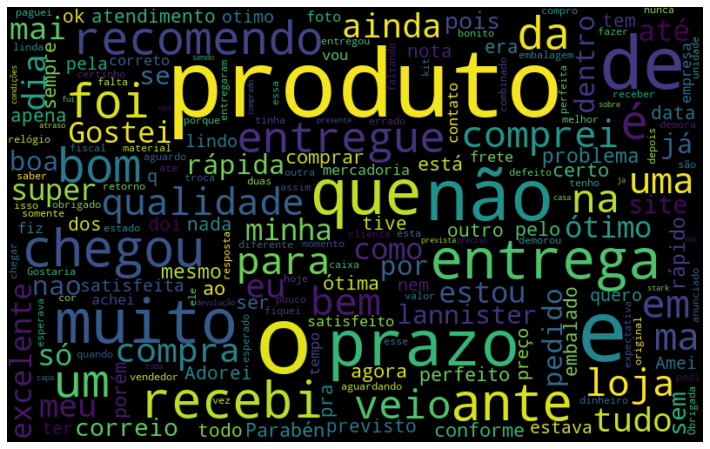

In [15]:
%matplotlib inline

# gerando a wordcloud
nuvem_palavras = WordCloud(width=800,\
                             height=500, 
                                max_font_size=110,\
                                    collocations=False).generate(todas_palavras)

# trasformando o objeto gerado em uma imagem
plt.figure(figsize=(14, 8))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis('off')
plt.show()

Sendo a base de dados um review da venda, logo, a palavra que possui maior número de ocorrência é "produto". Há também grande número de ocorrência de palavras que não agregam semanticamente no momento de criação do modelo, como por exemplo, "o", "que", "e", "da", "de" e "como".

Plotando palavras que nos remete a cada tipo de Score do Review:

In [16]:
# Criando dataframes para cada categoria de review
score_1 = dataset[dataset['review_score'] == 1]
score_2 = dataset[dataset['review_score'] == 2]
score_3 = dataset[dataset['review_score'] == 3]
score_4 = dataset[dataset['review_score'] == 4]
score_5 = dataset[dataset['review_score'] == 5]

Definindo uma função para criação das nuvem de palavras de acordo com o valor do score:

In [17]:
def nuvem_palavras(dataset, coluna_texto, n_score):
    score = dataset[dataset['review_score'] == n_score]
    palavras = ' '.join([texto for texto in score[coluna_texto]])
    # gerando a wordcloud
    nuvem_palavras = WordCloud(width=800,\
                                height=500, 
                                    max_font_size=110,\
                                        collocations=False).generate(palavras)

    # trasformando o objeto gerado em uma imagem
    plt.figure(figsize=(14, 8))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis('off')
    plt.show()

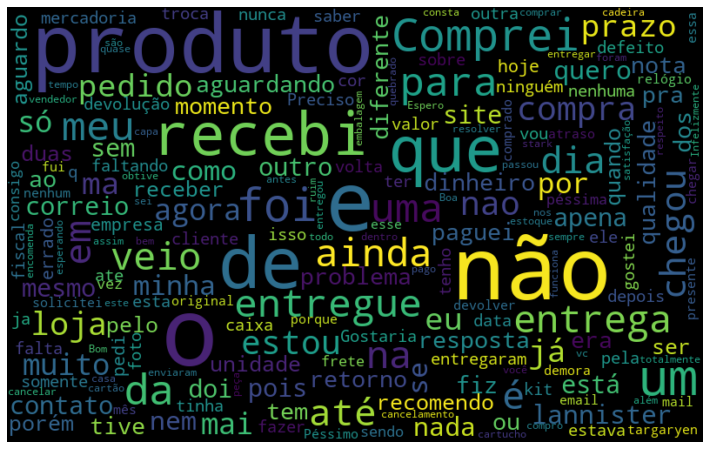

In [18]:
# Para o valor de score 1:
nuvem_palavras(dataset, 'review_comment_message', 1)

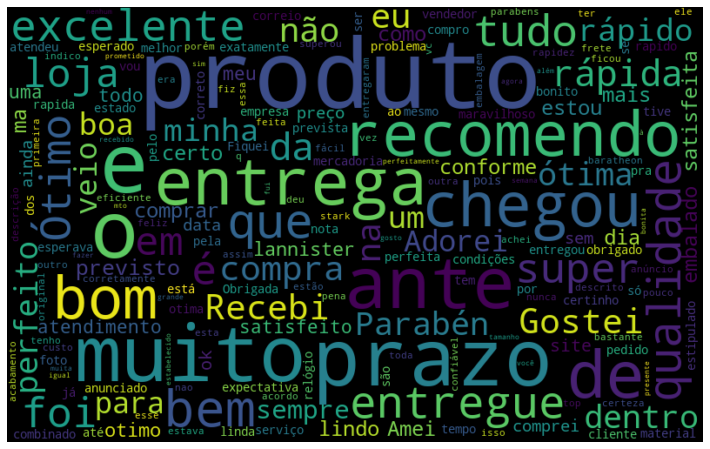

In [19]:
# Para o valor de score 5:
nuvem_palavras(dataset, 'review_comment_message', 5)

## NLTK

Calculo para frequência das palavras:

In [20]:
from nltk import FreqDist, tokenize

In [21]:
# Dividindo as strings uma lista de substrings:
token_espaco = tokenize.WhitespaceTokenizer()
token_espaco = token_espaco.tokenize(todas_palavras)

In [22]:
# Calculando a frência das palavras
# Irá ser retornado um dicionario com todas as palavras, onde a chave é palavra 
# o valor é número de ocorrência 
frequencia = nltk.FreqDist(token_espaco)

In [23]:
# Criando um dataframe com a frequencia
df_frequencia = pd.DataFrame({
    'Palavra' : list(frequencia.keys()),
    'Frequencia' : list(frequencia.values())
    })

df_frequencia.nlargest(columns='Frequencia', n=10)

,Palavra,Frequencia
39,o,14802
14,e,14746
50,produto,11069
122,de,10833
3,do,10813
16,a,10321
114,não,8298
37,que,7984
82,muito,5408
2,antes,5343
